In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

# Dosya yolları
INPUT_CSV = "DSA210-dataset.csv"      # ham veri (NO HEADER)
OUTPUT_CLEAN_CSV = "daily_clean.csv"

FIG_DIR = Path("figures")
RES_DIR = Path("results")
FIG_DIR.mkdir(exist_ok=True)
RES_DIR.mkdir(exist_ok=True)


In [2]:
# CSV: header yok, ilk 3 kolon: date, sweet, period
df = pd.read_csv(
    INPUT_CSV,
    header=None,
    names=["date", "sweets_consumed", "on_period"],
    usecols=[0, 1, 2],
    sep=None,
    engine="python"
)

# Tarih formatı: 9.09.2025 gibi -> dayfirst=True
df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["date"])

# Sayısal alanlar
df["sweets_consumed"] = pd.to_numeric(df["sweets_consumed"], errors="coerce")
df["on_period"] = pd.to_numeric(df["on_period"], errors="coerce")
df = df.dropna(subset=["sweets_consumed", "on_period"])

df["sweets_consumed"] = df["sweets_consumed"].astype(int)
df["on_period"] = df["on_period"].astype(int)

# Tarihe göre sırala
df = df.sort_values("date").reset_index(drop=True)

# Etiket kolon (plotlar için)
df["period_status"] = df["on_period"].map({0: "Not on period", 1: "On period"})

# Temiz veri kaydı (repoda dursun)
df.to_csv(OUTPUT_CLEAN_CSV, index=False)
df.head()


/var/folders/kb/6pl9jw516ll1p9zssmym43jm0000gn/T/ipykernel_65584/171010095.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")


,date,sweets_consumed,on_period,period_status
0,2025-09-09,1,0,Not on period
1,2025-09-10,1,1,On period
2,2025-09-11,0,1,On period
3,2025-09-12,1,1,On period
4,2025-09-13,0,1,On period


In [3]:
total_days = len(df)
on_days = int((df["on_period"] == 1).sum())
off_days = int((df["on_period"] == 0).sum())
mean_on = df[df["on_period"] == 1]["sweets_consumed"].mean()
mean_off = df[df["on_period"] == 0]["sweets_consumed"].mean()

eda_summary = f"""# EDA Summary

- Total number of days: {total_days}
- Number of days **on period**: {on_days}
- Number of days **not on period**: {off_days}

- Average sweet consumption on **period days**: {mean_on:.3f}
- Average sweet consumption on **non-period days**: {mean_off:.3f}
"""

print(eda_summary)

with open(RES_DIR / "eda_summary.md", "w", encoding="utf-8") as f:
    f.write(eda_summary)


# EDA Summary

- Total number of days: 81
- Number of days **on period**: 20
- Number of days **not on period**: 61

- Average sweet consumption on **period days**: 0.600
- Average sweet consumption on **non-period days**: 0.492



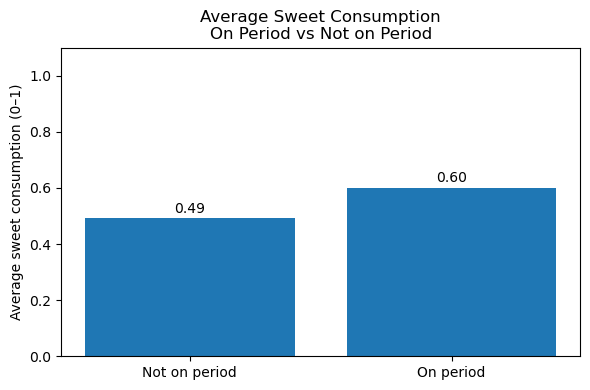

In [4]:
mean_by_status = df.groupby("period_status")["sweets_consumed"].mean().reindex(
    ["Not on period", "On period"]
)

plt.figure(figsize=(6, 4))
plt.bar(mean_by_status.index, mean_by_status.values)
plt.ylabel("Average sweet consumption (0–1)")
plt.title("Average Sweet Consumption\nOn Period vs Not on Period")
for i, v in enumerate(mean_by_status.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom")
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig(FIG_DIR / "01_bar_mean_sweets.png", dpi=300)
plt.show()


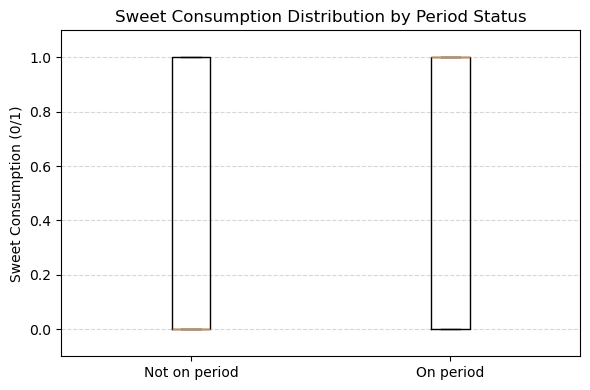

In [5]:
off_period = df[df["on_period"] == 0]["sweets_consumed"].values
on_period = df[df["on_period"] == 1]["sweets_consumed"].values

plt.figure(figsize=(6, 4))
plt.boxplot([off_period, on_period])
plt.xticks([1, 2], ["Not on period", "On period"])
plt.ylabel("Sweet Consumption (0/1)")
plt.title("Sweet Consumption Distribution by Period Status")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig(FIG_DIR / "02_box_sweets_by_period.png", dpi=300)
plt.show()


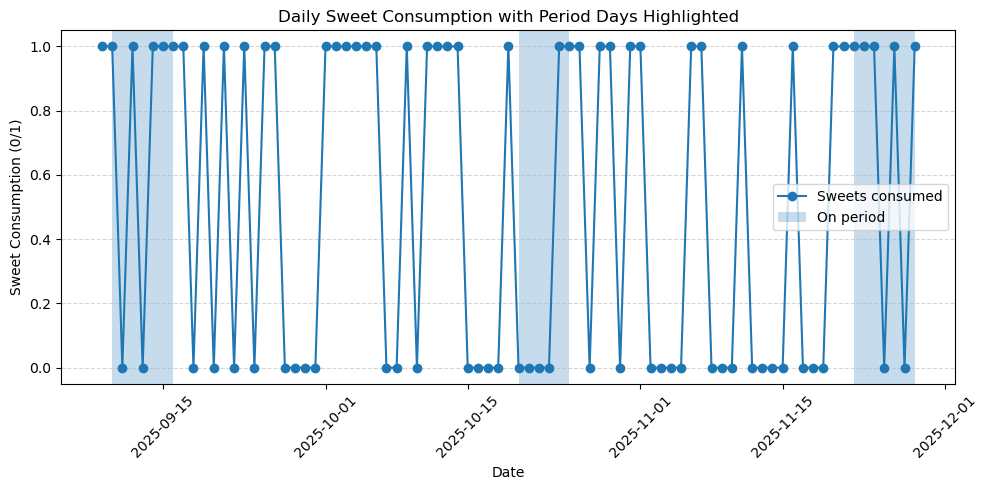

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(
    df["date"],
    df["sweets_consumed"],
    marker="o",
    linestyle="-",
    label="Sweets consumed"
)

y_min = -0.05
y_max = 1.05

plt.fill_between(
    df["date"],
    y_min,
    y_max,
    where=(df["on_period"] == 1),
    alpha=0.25,
    label="On period"
)

plt.ylim(y_min, y_max)
plt.xlabel("Date")
plt.ylabel("Sweet Consumption (0/1)")
plt.title("Daily Sweet Consumption with Period Days Highlighted")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_DIR / "03_timeseries_sweets_period.png", dpi=300)
plt.show()


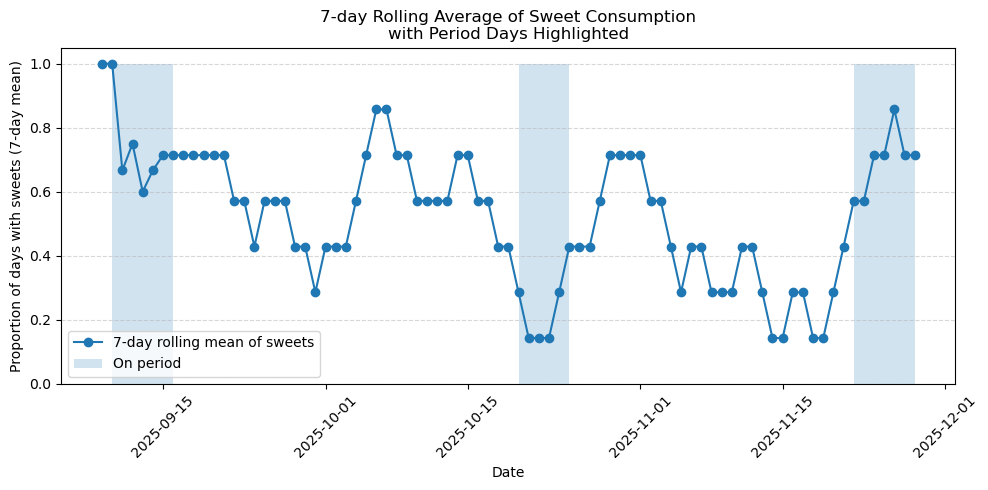

In [7]:
df_rolling = df.set_index("date").copy()
df_rolling["rolling_7d_mean"] = df_rolling["sweets_consumed"].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(
    df_rolling.index,
    df_rolling["rolling_7d_mean"],
    marker="o",
    linestyle="-",
    label="7-day rolling mean of sweets"
)

plt.fill_between(
    df_rolling.index,
    0,
    1.0,
    where=(df_rolling["on_period"] == 1),
    alpha=0.2,
    label="On period"
)

plt.ylim(0, 1.05)
plt.xlabel("Date")
plt.ylabel("Proportion of days with sweets (7-day mean)")
plt.title("7-day Rolling Average of Sweet Consumption\nwith Period Days Highlighted")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_DIR / "04_rolling_mean_sweets.png", dpi=300)
plt.show()



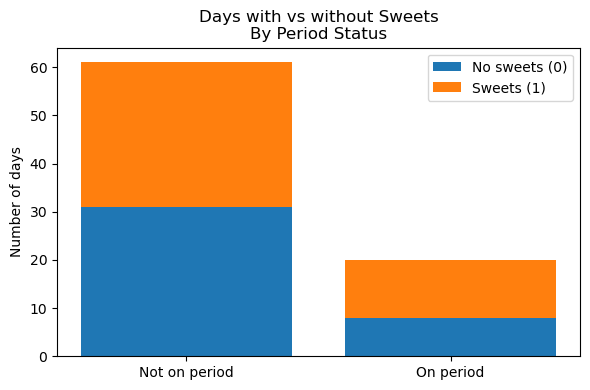

In [8]:
crosstab = pd.crosstab(df["period_status"], df["sweets_consumed"])
for val in [0, 1]:
    if val not in crosstab.columns:
        crosstab[val] = 0
crosstab = crosstab[[0, 1]]

labels = crosstab.index.tolist()
no_sweets = crosstab[0].values
yes_sweets = crosstab[1].values
x = np.arange(len(labels))

plt.figure(figsize=(6, 4))
plt.bar(x, no_sweets, label="No sweets (0)")
plt.bar(x, yes_sweets, bottom=no_sweets, label="Sweets (1)")
plt.xticks(x, labels)
plt.ylabel("Number of days")
plt.title("Days with vs without Sweets\nBy Period Status")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "05_stacked_sweets_counts.png", dpi=300)
plt.show()


In [9]:
def welch_t_test(x, y):
    """Manual Welch t-test (normal approximation, no SciPy)."""
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    n1, n2 = len(x), len(y)
    mean1, mean2 = x.mean(), y.mean()
    var1, var2 = x.var(ddof=1), y.var(ddof=1)

    se = math.sqrt(var1 / n1 + var2 / n2)
    t_stat = 0.0 if se == 0 else (mean1 - mean2) / se

    def normal_cdf(z):
        return 0.5 * (1.0 + math.erf(z / math.sqrt(2)))

    p_two_sided = 2 * (1 - normal_cdf(abs(t_stat)))
    p_one_sided = 1 - normal_cdf(t_stat) if t_stat > 0 else normal_cdf(t_stat)

    return t_stat, p_two_sided, p_one_sided


In [10]:
t_stat, p_two, p_one = welch_t_test(on_period, off_period)
alpha = 0.05

hypo_summary = f"""# Hypothesis Test Summary

- Mean sweets **ON period days**:  {on_period.mean():.3f}
- Mean sweets **OFF period days**: {off_period.mean():.3f}

We test:

- H₀: mean_sweets_on_period ≤ mean_sweets_off_period  
- H₁: mean_sweets_on_period  > mean_sweets_off_period  

Manual Welch t-test (normal approximation):

- t-statistic: {t_stat:.4f}
- One-sided p-value (H₁: mean_on > mean_off): {p_one:.4f}
- Significance level α = {alpha:.2f}
"""

if p_one < alpha:
    decision = (
        "Decision: **REJECT** the null hypothesis (H₀).\n"
        "Conclusion: The data provides statistical evidence that sweet consumption "
        "is higher on period days."
    )
else:
    decision = (
        "Decision: **FAIL TO REJECT** the null hypothesis (H₀).\n"
        "Conclusion: The data does **not** provide enough evidence that sweet "
        "consumption is higher on period days."
    )

hypo_summary += "\n" + decision + "\n"

print(hypo_summary)

with open(RES_DIR / "hypothesis_summary.md", "w", encoding="utf-8") as f:
    f.write(hypo_summary)


# Hypothesis Test Summary

- Mean sweets **ON period days**:  0.600
- Mean sweets **OFF period days**: 0.492

We test:

- H₀: mean_sweets_on_period ≤ mean_sweets_off_period  
- H₁: mean_sweets_on_period  > mean_sweets_off_period  

Manual Welch t-test (normal approximation):

- t-statistic: 0.8348
- One-sided p-value (H₁: mean_on > mean_off): 0.2019
- Significance level α = 0.05

Decision: **FAIL TO REJECT** the null hypothesis (H₀).
Conclusion: The data does **not** provide enough evidence that sweet consumption is higher on period days.

